In [149]:
import numpy as np
import matplotlib.pyplot as plt
from cartpole_lib_python import *
import odrive

In [2]:
init_odrive()

axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.CANCELLED
  last_drv_fault: none
internal issues: none
odrive initialized


In [3]:
odrv = get_odrive()
odrive.utils.dump_errors(odrv)

axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.CANCELLED
  last_drv_fault: none
internal issues: none


In [25]:
print(get_state())

[-0.05758084508417206, -2.8355634864067945, 1.3372258413376651e-05, -0.047582789390888336]


In [410]:
xg = np.array([0, -2.790311053164165, 0, 0])
measurement = get_measurement() - xg[:2]
print(measurement)

[-5.9202071e-04  3.0023839e+00]


In [191]:
traj = np.load("swingup/traj.npz")
X_ref = traj["X_np"]
U_ref = traj["U_np"]

In [412]:
control_frequency = 60 # Hz
control_period = 1/control_frequency
h = control_period
T = 3 # runtime, seconds
N = int(T*control_frequency)
print("N: ", N)

xg = np.array([0, -2.792311053164165, 0, 0])

# 60 hz

div = 2.0

# Long pole
k_matrix = np.array([-5.29489, -19.36664, -4.46195, -3.79850/2]) * .2
A = np.array([[1.0000000000, -0.0003967107, 0.0166666667, -0.0000022013/div],
              [0.0000000000, 1.0071773311, 0.0000000000, 0.0167064931/div],
              [0.0000000000, -0.0476620907, 1.0000000000, -0.0003967107/div],
              [0.0000000000, 0.8623075615, 0.0000000000, 1.0071773311/div]])
B = np.array([[0.00071],
              [-0.0028918346],
              [0.0850797930],
              [-0.3474342796]])

mc = 0.177 # mass of the cart (kg)
mp = 0.076 # mass of the pole (kg)
ℓ = 0.29845 # distance to the center of mass (meters)

g = 9.81

h = 1/60

def cartpole_dynamics(x,u)
    r = x[1] # cart position
    θ = x[2] # pole angle
    rd = x[3] # change in cart position
    θd = x[4] # change in pole angle
    F = u[1] # force applied to cart
    
    θdd = (g*sin(θ) + cos(θ) * ((-F - mp*ℓ*(θd^2) * sin(θ))/(mc + mp))) / (ℓ*(4/3 - (mp*(cos(θ)^2))/(mc + mp)))
    rdd = (F + mp*ℓ*((θd^2)*sin(θ) - θdd*cos(θ))) / (mc + mp)
  
    return [rd; θd; rdd; θdd]

def cartpole_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = cartpole_dynamics(x, u)
    f2 = cartpole_dynamics(x + 0.5*h*f1, u)
    f3 = cartpole_dynamics(x + 0.5*h*f2, u)
    f4 = cartpole_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    return xn

# Short pole

# k_matrix = np.array([-2.03489, -19.35213, -2.92774, -3.95801/div]) * .2
# k_matrix = np.array([-6.35349, -25.13689, -5.37781, -4.61270/div]) * .2
# A = np.array([[ 1.0,  -0.00121865,  0.0166667,  -6.75843e-6/div],
#             [ 0.0,   1.01053,     0.0,         0.0167251/div],
#             [ 0.0,  -0.146494,    1.0,        -0.00121865/div],
#             [ 0.0,   1.2659,      0.0,         1.01053/div]])
# B = np.array([[0.000551601873215193],
#             [-0.00225045660570214],
#             [0.06624688343408017],
#             [-0.2705271146990864]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

meas_noise_cov = np.diag([.1, .1]) # most recent
process_noise_cov = np.diag([1, 1, 50, 50]) # position, angle, linear velocity, angular velocity

nx = process_noise_cov.shape[0]
def kf_update(x_meas, x_pred_prev, est_cov_prev):
    Kn = est_cov_prev@H.T @ np.linalg.inv(H@est_cov_prev@H.T + meas_noise_cov)
    x = x_pred_prev + Kn @ (x_meas - H@x_pred_prev)
    est_cov = (np.eye(nx) - Kn@H) @ est_cov_prev @ (np.eye(nx) - Kn@H).T + Kn@meas_noise_cov@Kn.T
    return x, est_cov

def kf_predict(state, control, est_cov):
    x_pred = A@state + B@control
    est_cov_pred = A@est_cov@A.T + process_noise_cov
    return x_pred, est_cov_pred

# Initialize Kalman filter variables
# First state estimate
meas = get_measurement() - xg[:2]
x = np.array([meas[0], meas[1], 0, 0])
x_pred_prev = x
# Estimation covariance
est_cov = np.eye(4)*20
est_cov_prev = est_cov

xs = np.zeros(np.append(x.shape, N))
measurements = np.zeros((2,N))
controls = np.zeros(N)
control_clamp = .5

measure_times = []
control_times = []
command_times = []
loop_times = []

for i in range(N):
# i = 0
# while True:
    time_start = time.perf_counter()
    
    measurement = get_measurement() - xg[:2]
    measure_times.append(time.perf_counter() - time_start)
    if i > 0:
        x, est_cov = kf_update(measurement, x_pred_prev, est_cov_prev)
    
    xs[:,i] = x
    measurements[:,i] = measurement
    control = -k_matrix @ x
    control = min(control_clamp, max(-control_clamp, control))
    
    control_times.append(time.perf_counter() - time_start)
    
    x_pred_prev, est_cov_prev = kf_predict(x, [control], est_cov)
    
    command_linear_torque(-control)
    # command_linear_torque(0)
    controls[i] = control
    
    # if measurement[1] < -2 or measurement[1] > 2:
    #     break
    
    # i += 1
    command_times.append(time.perf_counter() - time_start)
    busy_sleep(control_period, time_start, get_now=time.perf_counter)
    loop_times.append(time.perf_counter() - time_start)


command_linear_torque(0)

N:  180


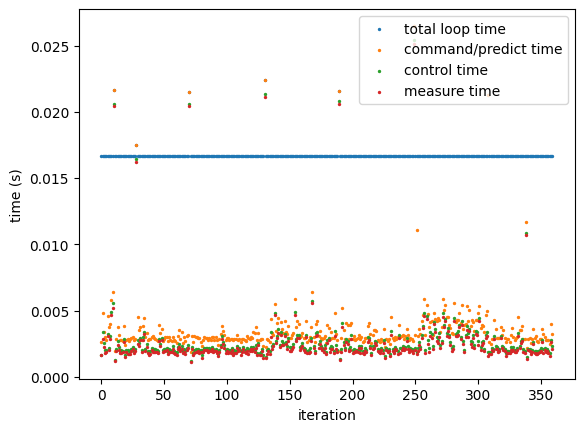

In [72]:
plt.scatter(range(len(loop_times)), np.array(loop_times), s=2, label="total loop time")
plt.scatter(range(len(loop_times)), np.array(command_times), s=2, label="command/predict time")
plt.scatter(range(len(loop_times)), np.array(control_times), s=2, label="control time")
plt.scatter(range(len(loop_times)), np.array(measure_times), s=2, label="measure time")

# plt.ylim([0,.05])
plt.legend()
plt.ylabel("time (s)")
plt.xlabel("iteration")

plt.show()

In [66]:
for i in range(3):
    start = time.perf_counter()
    command_linear_torque(.1)
    busy_sleep(.1, start, get_now=time.perf_counter)
    command_linear_torque(-.1)
    busy_sleep(.2, start, get_now=time.perf_counter)
command_linear_torque(0)

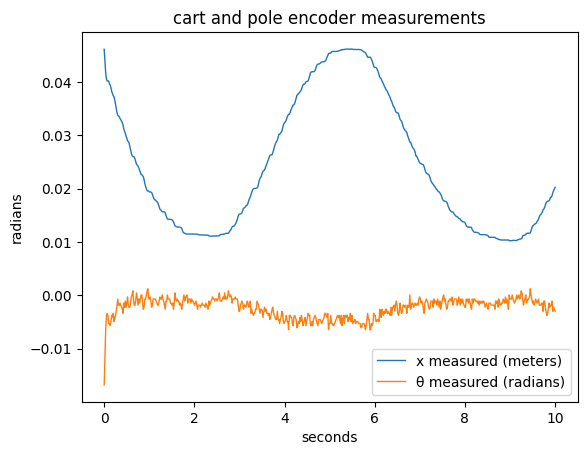

In [84]:
# plt.plot(np.linspace(0, len(measurements[0])//60, len(measurements[0])), measurements[1,:], color='orange',linewidth=1)
plt.plot(np.linspace(0, len(measurements[0])//60, len(measurements[0])), measurements.T, linewidth=1)
# plt.plot(measurements[1,:], linewidth=1)
# plt.ylim([-0.1, 0.04])
# plt.xlim([2.666, 3.7])
plt.legend(['x measured (meters)', 'θ measured (radians)'])
# plt.legend(['θ measured (rad)'])
# plt.grid()
plt.title('cart and pole encoder measurements')
plt.xlabel('seconds')
plt.ylabel('radians')
plt.show()

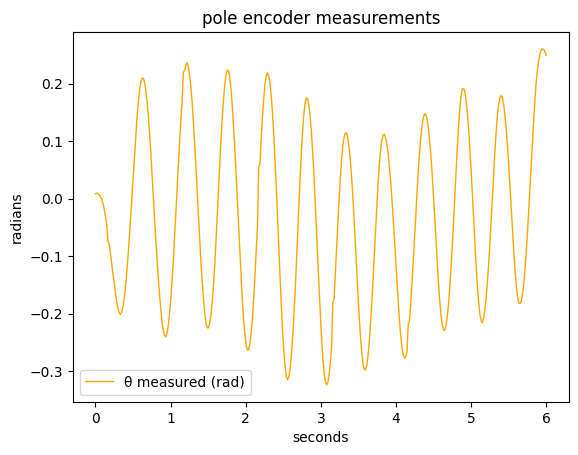

In [74]:
plt.plot(np.linspace(0, len(measurements[0])//60, len(measurements[0])), measurements[1,:], color='orange',linewidth=1)
# plt.ylim([-0.006, 0.01])
# plt.xlim([2, 3.7])
plt.legend(['θ measured (rad)'])
plt.title('pole encoder measurements')
plt.xlabel('seconds')
plt.ylabel('radians')
plt.show()

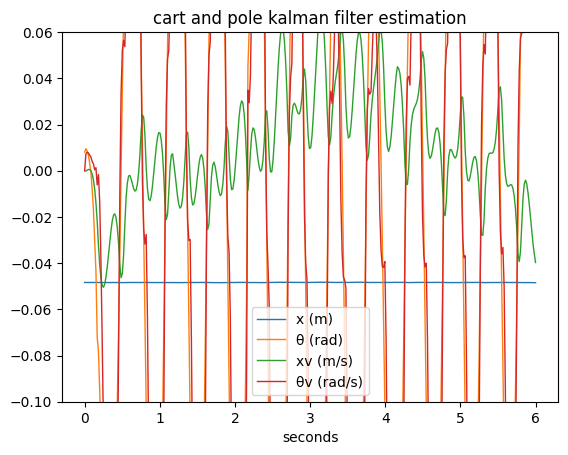

In [75]:
xs_plt = xs
xs_plt[3,:] *= 2
plt.plot(np.linspace(0, len(measurements[0])//60, len(measurements[0])), xs.T, '-', linewidth=1)
# plt.plot(np.linspace(0, len(measurements[0])//60, len(measurements[0])), xs[3,:], '-', color='red', linewidth=1)
plt.title('cart and pole kalman filter estimation')
plt.legend(['x (m)', 'θ (rad)', 'xv (m/s)', 'θv (rad/s)'])
# plt.legend(['θv (m/s)'])
plt.ylim([-0.1, 0.06])
plt.xlabel('seconds')
plt.show()

Text(0.5, 1.0, 'control input')

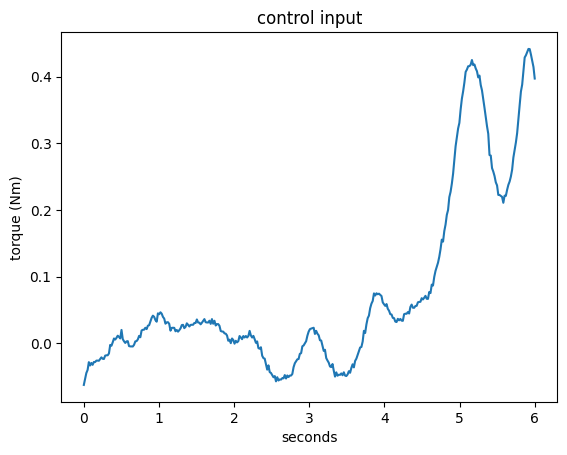

In [78]:
plt.plot(np.linspace(0, len(measurements[0])//60, len(measurements[0])), controls)
# plt.ylim([-.07, .07])
plt.ylabel('torque (Nm)')
plt.xlabel('seconds')
plt.title('control input')